In [95]:
import pandas as pd
import boto3
from difflib import get_close_matches
import numpy as np
import os
from dotenv import load_dotenv
import json


In [96]:
def map_neighborhood(neighborhood):
    # Lista de valores permitidos
    valid_neighborhoods = [
        'ALMAGRO', 'BALVANERA', 'BELGRANO', 'CABALLITO', 'COLEGIALES', 'DEVOTO',
        'FLORES', 'MONTSERRAT', 'NUNEZ', 'PALERMO', 'PARQUE PATRICIOS', 'PUERTO MADERO',
        'RECOLETA', 'RETIRO', 'SAN NICOLAS', 'SAN TELMO', 'VILLA CRESPO', 'VILLA DEL PARQUE', 'VILLA URQUIZA'
    ]

    neighborhood = neighborhood.upper()  # Convertimos a mayúsculas para estandarizar
    
    # Mapeos directos conocidos
    manual_mappings = {
        'MONSERRAT': 'MONTSERRAT',
        'NUÑEZ': 'NUNEZ',
        'CONGRESO': 'BALVANERA',
        'BARRIO NORTE': 'RECOLETA',
        'TRIBUNALES': 'SAN NICOLAS',
        'MICROCENTRO': 'SAN NICOLAS',
        'CENTRO / MICROCENTRO': 'SAN NICOLAS',
        'BARRACAS': 'PARQUE PATRICIOS',
        'CONSTITUCIÓN': 'SAN TELMO',
        'POMPEYA': 'PARQUE PATRICIOS',
        'MATADEROS': 'FLORES',
        'LINIERS': 'FLORES',
        'VERSALLES': 'VILLA URQUIZA',
        'VILLA SOLDATI': 'PARQUE PATRICIOS',
        'VILLA RIACHUELO': 'PARQUE PATRICIOS',
        'VILLA LUGANO': 'PARQUE PATRICIOS',
        'LA PATERNAL': 'VILLA CRESPO',
        'COGHLAN': 'BELGRANO',
        'LAS CAÑITAS': 'BELGRANO',
        'VILLA PUEYRREDÓN': 'VILLA URQUIZA',
        'BOTÁNICO': 'PALERMO',
        'BOEDO': 'ALMAGRO',
        'CHACARITA': 'VILLA CRESPO',
        'PALERMO HOLLYWOOD': 'PALERMO',
        'SAN CRISTOBAL': 'BALVANERA',
        'SAAVEDRA': 'NUNEZ',
        'AGRONOMÍA': 'VILLA DEL PARQUE',
        'BARRIO PARQUE': 'PALERMO',
        'ONCE': 'BALVANERA',
        'BARRIO CHINO': 'BELGRANO',
        'LOMAS DE NÚÑEZ': 'NUNEZ',
        'LA BOCA': 'SAN TELMO',
        'MONTE CASTRO': 'DEVOTO',
        'CID CAMPEADOR': 'VILLA CRESPO',
        'BARRIO PARQUE GENERAL BELGRANO': 'BELGRANO',
        'PRIMERA JUNTA': 'CABALLITO',
        'VELEZ SARSFIELD': 'FLORES',
        'PARQUE AVELLANEDA': 'FLORES',
        'DISTRITO QUARTIER': 'PUERTO MADERO',
        'TEMPERLEY': 'FLORES',  # No está en CABA, asignado al más cercano
        'CATALINAS': 'RETIRO',
        'LOS PERALES': 'FLORES',
        'NAÓN': 'VILLA DEL PARQUE',
        'PATERNAL': 'VILLA CRESPO',
        'BOCA': 'SAN TELMO',
        'CONSTITUCION': 'SAN TELMO',
        'DEPARTAMENTO EN VENTA EN CABALLITO': 'CABALLITO',
        'DEPARTAMENTO EN VENTA EN PALERMO': 'PALERMO',
        'AGRONOMIA': 'VILLA DEL PARQUE'
    }
    
    if neighborhood in manual_mappings:
        return manual_mappings[neighborhood]
    
    # Buscar coincidencias aproximadas
    match = get_close_matches(neighborhood, valid_neighborhoods, n=1, cutoff=0.6)
    return match[0] if match else 'OTRO'

In [97]:
df_argenprop = pd.read_excel("StockArgenprop.xlsx")

In [147]:
df_raw = pd.read_excel("StockArgenprop.xlsx")
df_raw.shape

(536969, 26)

In [98]:
df_argenprop.drop(columns=["FechaPublicacion", "FechaModificacion"], inplace=True)

In [99]:
# Hacemos algunos filtros

df_argenprop = df_argenprop[df_argenprop["MontoOperacion"].notnull()]
df_argenprop = df_argenprop[df_argenprop["MontoOperacion"] != 0]
df_argenprop = df_argenprop[df_argenprop["TipoOperacion"] == "Alquiler"]
df_argenprop = df_argenprop[df_argenprop["Pais"] == "Argentina"]
df_argenprop = df_argenprop[df_argenprop["Provincia"] == "Capital Federal"]
df_argenprop = df_argenprop[df_argenprop["Barrio"].notnull()]
df_argenprop = df_argenprop[df_argenprop["TipoPropiedad"].isin(["Departamento", "Casa"])]




In [100]:
# Para antiguedad, si no tenemos valor, llenamos con el valor promedio del resto de las antiguedades
# en el barrio
df_argenprop['Antiguedad'] = df_argenprop['Antiguedad'].fillna(
    df_argenprop.groupby('Barrio')['Antiguedad'].transform('mean')
)

# Round up to the nearest natural number
df_argenprop['Antiguedad'] = np.ceil(df_argenprop['Antiguedad'])

# Para muchos casos no tenemos antiguedad por promedio. Tomamos información de Internet y las rellenamos
avg_antiquity = {
    "Recoleta": 50,  # Historical, many buildings from early 20th century
    "Núñez": 40,  # Mix of older houses and newer developments
    "Palermo Hollywood": 30,  # Many mid-century and newer constructions
    "Puerto Madero": 20,  # Mostly new developments since the 1990s
    "Centro / Microcentro": 70,  # Historic center with older buildings
    "Las Cañitas": 40,  # Trendy area with a mix of old and new
    "Palermo Soho": 40,  # Similar to Hollywood, slightly older buildings
    "Monte Castro": 50,  # Traditional residential area
    "Almagro Norte": 60,  # Older residential area
    "Tribunales": 80,  # Historic legal and business district
    "San Nicolás": 70,  # Similar to Microcentro
    "Monserrat": 80,  # One of the oldest neighborhoods
    "Belgrano R": 50,  # Residential, mix of old and newer homes
    "Palermo Nuevo": 30,  # Newer part of Palermo
    "Palermo Chico": 40,  # Upscale, many mid-century properties
    "Belgrano Chico": 40,  # Similar to Palermo Chico
    "Palermo Viejo": 50,  # Older buildings, many renovated
    "Retiro": 70,  # Historic with some modern developments
    "La Paternal": 50,  # Older residential neighborhood
    "Caballito Norte": 60,  # Older family homes
    "Belgrano C": 50,  # Similar to Belgrano R
    "Caballito Sur": 60,  # Same as Norte
    "Parque Rivadavia": 60,  # Older buildings near park
    "Villa Pueyrredón": 50,  # Traditional middle-class area
    "Floresta Sur": 60,  # Mix of old houses and mid-century buildings
    "Primera Junta": 60,  # Similar to Caballito
    "Cid Campeador": 60,  # Similar to surrounding areas
    "Constitución": 80,  # Old and densely built
    "Botánico": 40,  # Around the gardens, mix of styles
    "Lomas de Núñez": 30,  # Newer developments
    "Distrito Quartier": 20,  # Newly developed
    "Temperley": 70,  # Older suburb
    "Flores Sur": 60,  # Similar to Floresta
    "Almagro Sur": 60,  # Similar to Norte
    "Flores Norte": 60,  # Same as Sur
    "La Boca": 80,  # Historic with some modern projects
    "Parque Chas": 50,  # Traditional middle-class area
    "Floresta Norte": 60,  # Similar to Sur
    "Agronomía": 50,  # Near university, mix of styles
    "Otro": 50,  # Placeholder for undefined neighborhoods
    "Puerto Retiro": 70,  # Near historic Retiro
    "Barrio Parque": 40,  # Upscale, mid-century
    "Barrio Chino": 30,  # Newer commercial developments
    "Naón": 50,  # Mix of older homes
    "Parque Avellaneda": 60,  # Similar to Parque Chas
    "Catalinas": 20,  # Modern skyscrapers
    "Los Perales": 50,  # Traditional residential
    "Villa Riachuelo": 50,  # Outlying older area
    "Barrio Parque General Belgrano": 50  # Older homes, quieter
}

def antiquity_filler(neighborhood):
    return avg_antiquity.get(neighborhood, 50)

df_argenprop.loc[df_argenprop["Antiguedad"].isna(), "Antiguedad"] = df_argenprop.loc[df_argenprop["Antiguedad"].isna()]["Barrio"].apply(antiquity_filler)

/var/folders/nh/hlj82q8x3lb09bztb9v347pwp22f50/T/ipykernel_78135/2057130370.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_argenprop.loc[df_argenprop["Antiguedad"].isna(), "Antiguedad"] = df_argenprop.loc[df_argenprop["Antiguedad"].isna()]["Barrio"].apply(antiquity_filler)


In [101]:
df_argenprop['neighborhood'] = df_argenprop['Barrio'].apply(map_neighborhood)
# Si el precio esta en dolares, lo pasamos a pesos
df_argenprop['MontoOperacion'] = df_argenprop.apply(lambda x: x['MontoOperacion'] * 1225 if x['Nombre'] == 'Dolares' else x['MontoOperacion'], axis=1)
df_argenprop.drop(columns=["Nombre"], inplace=True)

# Si PropiedadSuperficieTotal es NaN, lo reemplazamos por PropiedadSuperficieCubierta
df_argenprop['PropiedadSuperficieTotal'] = df_argenprop.apply(lambda x: x['SuperficieCubierta'] if pd.isna(x['PropiedadSuperficieTotal']) else x['PropiedadSuperficieTotal'], axis=1)
df_argenprop.drop(columns=["SuperficieCubierta", "SuperficieDescubierta"], inplace=True)

In [102]:
df_argenprop.drop(columns=["CantidadAmbientes"], inplace=True)
df_argenprop.drop(columns=["Pais", "Provincia", "Localidad", "Calle", "Numero", "Piso", "Barrio", "SubBarrio", "Latitud", "Longitud", "Departamento", "TipoOperacion", "CantidadCocheras", "DepartamentoExpensas"], inplace=True)


In [103]:
# Quitamos los campos con PropiedadSuperficieTotal en 0 o NaN
df_argenprop = df_argenprop[df_argenprop["PropiedadSuperficieTotal"].notnull()]
df_argenprop = df_argenprop[df_argenprop["PropiedadSuperficieTotal"] != 0]

def meter_converter(total_surface):
    if total_surface < 30:
        return 1
    elif total_surface < 50:
        return 2
    elif total_surface < 80:
        return 3
    elif total_surface < 120:
        return 4
    elif total_surface < 200:
        return 5
    return 6

# Si CantidadDormitorios es 0 o NaN aplicamos la funcion meter_converter
df_argenprop['CantidadDormitorios'] = df_argenprop.apply(lambda x: meter_converter(x['PropiedadSuperficieTotal']) if pd.isna(x['CantidadDormitorios']) or x['CantidadDormitorios'] == 0 else x['CantidadDormitorios'], axis=1)

In [104]:
df_argenprop.drop(columns=["TipoPropiedad"], inplace=True)

In [105]:
df_argenprop.rename(columns={"Codigo": "argenprop_code", 
                             "MontoOperacion": "original_price", 
                             "PropiedadSuperficieTotal": "total_area", 
                             "CantidadDormitorios": "rooms",
                             "Antiguedad": "antiquity"}, inplace=True)
df_argenprop

,argenprop_code,original_price,total_area,rooms,antiquity,neighborhood
276764,6EBM_5,400000.0,45.0,1.0,22.0,CABALLITO
276769,3OMX_146196,300000.0,23.0,1.0,0.0,CABALLITO
276782,BTS1329_LP723065_1,428750.0,25.0,1.0,0.0,CABALLITO
276785,AR.42.53.104.487.V1,480000.0,54.0,1.0,19.0,CABALLITO
276786,160828-6218964,1102500.0,50.0,1.0,22.0,CABALLITO
...,...,...,...,...,...,...
397145,BK803710,350000.0,33.0,2.0,0.0,VILLA URQUIZA
397156,OWZ_96,588000.0,50.0,2.0,15.0,VILLA URQUIZA
397168,DG211391,600000.0,46.0,1.0,20.0,VILLA URQUIZA
397178,PRO-1226719,857500.0,34.0,2.0,0.0,VILLA URQUIZA


In [106]:
original_data = df_argenprop.to_dict(orient="records")

In [107]:
for data in original_data:
    if data["rooms"] == 1:
        data["bedrooms"] = 2
    else:
        data["bedrooms"] = data["rooms"] - 1

    data["bathrooms"] = 1
    data["garages"] = 1

In [108]:
"""
{
  "total_area": 40,
  "rooms": 2,
  "bedrooms": 1,
  "bathrooms": 1,
  "garages": 1,
  "antiquity": 50
}
"""

model_wo_ohe_lambda = "valorar-inference-iBiiyZPxzsMt"
model_w_ohe_lambda = "valorar-inference-ohe-PX2BhKiczrDk"
model_w_neighborhood_lambda = "valorar-inference-ohe-ByNeighborhood-4lTUzUA5OdoE"

load_dotenv()
session = boto3.Session(
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY_ID')
)
lambda_client = session.client('lambda')


In [109]:
def get_rent_result(payload, lambda_client, function_name):
    response = lambda_client.invoke(
        FunctionName=function_name,
        InvocationType="RequestResponse",
        Payload=json.dumps(payload)
    )

    response_json = json.loads(response["Payload"].read())
    body_json = json.loads(response_json["body"])
    print(body_json)
    return body_json["prediction"][0]

In [111]:
tmp = pd.DataFrame(original_data)
tmp.to_csv("ArgenpropData.csv", index=False)

In [118]:
# {'argenprop_code': '6EBM_5', 'original_price': 400000.0, 'total_area': 45.0, 'rooms': 1.0, 'antiquity': 22.0, 'neighborhood': 'CABALLITO', 'bedrooms': 2, 'bathrooms': 1, 'garages': 1}

# Trabajamos sobre una sample
import random

def get_sample(data, sample_size):
    """
    Get a random sample from a list of dictionaries.

    Parameters:
    data (list): The list of dictionaries.
    sample_size (int): The number of samples to take.

    Returns:
    list: A random sample of dictionaries.
    """
    if sample_size > len(data):
        raise ValueError("Sample size cannot be larger than the dataset size")

    return random.sample(data, sample_size)

sample_data = get_sample(original_data, 500)

n = 1
for data in sample_data:

    simple_payload = {
        "total_area": int(data["total_area"]),
        "rooms": int(data["rooms"]),
        "bedrooms": int(data["bedrooms"]),
        "bathrooms": int(data["bathrooms"]),
        "garages": int(data["garages"]),
        "antiquity": int(data["antiquity"])
    }

    neighborhood_payload = simple_payload.copy()
    neighborhood_payload["neighborhood"] = data["neighborhood"]

    print("Obtaining predictions for property with code", data["argenprop_code"], n, "of", len(sample_data))
    n += 1
    data["simple_prediction"] = get_rent_result(simple_payload, lambda_client, model_wo_ohe_lambda)
    data["ohe_prediction"] = get_rent_result(neighborhood_payload, lambda_client, model_w_ohe_lambda)
    data["neighborhood_prediction"] = get_rent_result(neighborhood_payload, lambda_client, model_w_neighborhood_lambda)



Obtaining predictions for property with code PRO-1247609 1 of 500
{'prediction': ['[377699.16518557]']}
{'prediction': ['[444659.24038764]']}
{'prediction': [454730.07686781936]}
Obtaining predictions for property with code BPS2468 2 of 500
{'prediction': ['[519898.11872423]']}
{'prediction': ['[477154.17394995]']}
{'prediction': [661222.0522035249]}
Obtaining predictions for property with code AR.42.48.184.92.V1 3 of 500
{'prediction': ['[1049319.56466683]']}
{'prediction': ['[1316860.84373948]']}
{'prediction': [1192393.3797498038]}
Obtaining predictions for property with code AR.42.139.95.16 4 of 500
{'prediction': ['[510425.21569494]']}
{'prediction': ['[574252.62567748]']}
{'prediction': [621877.7864652612]}
Obtaining predictions for property with code PRO-1254322 5 of 500
{'prediction': ['[370484.9633982]']}
{'prediction': ['[383368.00188256]']}
{'prediction': [348228.48744328273]}
Obtaining predictions for property with code LEP-LE1-46402-581 6 of 500
{'prediction': ['[477896.91

In [114]:
for data in sample_data:
    data["simple_prediction"] = data["simple_prediction"][0]
    data["ohe_prediction"] = data["ohe_prediction"][0]

In [116]:
df_sample = pd.DataFrame(sample_data)
df_sample.to_csv("ArgenpropSample.csv", index=False)

In [117]:
df_sample

,argenprop_code,original_price,total_area,rooms,antiquity,neighborhood,bedrooms,bathrooms,garages,simple_prediction,ohe_prediction,neighborhood_prediction
0,BTS1025_LP738049_1,5145000.0,98.0,3.0,10.0,PALERMO,2.0,1,1,[,[,1.094033e+06
1,AR.42.61.262.140.V2,600000.0,62.0,2.0,44.0,ALMAGRO,1.0,1,1,[,[,6.858408e+05
2,PRO-1244421,10412500.0,315.0,3.0,0.0,PALERMO,2.0,1,1,[,[,1.054817e+06
3,PRO-1248710,918750.0,40.0,2.0,27.0,PALERMO,1.0,1,1,[,[,5.785239e+05
4,CT881635,1347500.0,160.0,4.0,45.0,VILLA CRESPO,3.0,1,1,[,[,8.833588e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
495,RAM1421,400000.0,40.0,2.0,0.0,PARQUE PATRICIOS,1.0,1,1,[,[,6.462366e+05
496,AR.42.201.8.32,950000.0,70.0,1.0,6.0,BELGRANO,2.0,1,1,[,[,7.122047e+05
497,PRO-1144864,650000.0,30.0,1.0,35.0,RETIRO,2.0,1,1,[,[,6.013709e+05
498,ABE1805,750000.0,80.0,2.0,55.0,RECOLETA,1.0,1,1,[,[,8.459054e+05


In [2]:
import pandas as pd

df_final = pd.read_csv("output-final.csv")

In [3]:
df_final.shape

(9312, 12)

In [4]:
df_final = df_final.loc[df_final.original_price < 5000000]

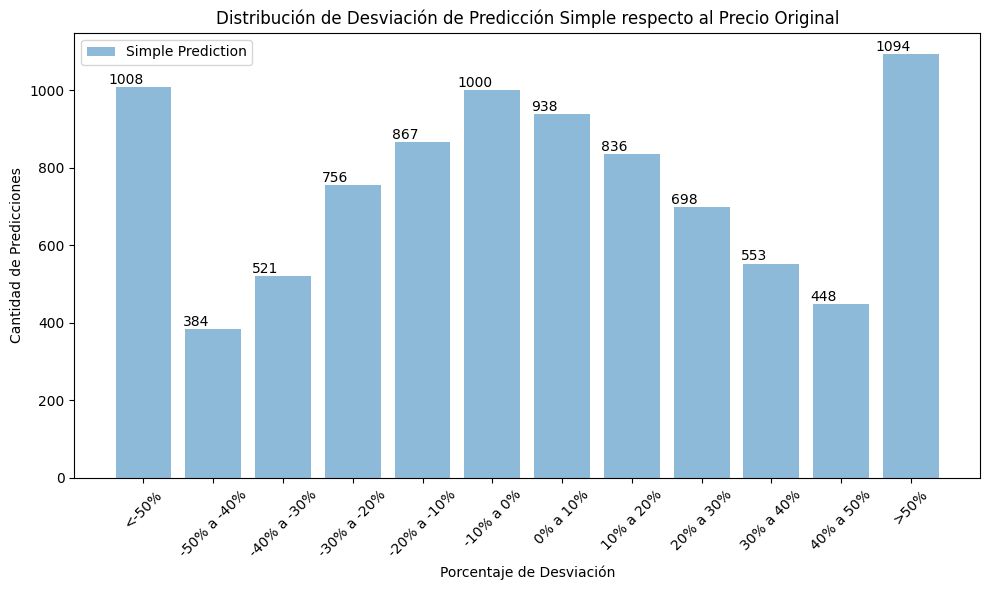

In [5]:
import matplotlib.pyplot as plt

df = df_final

# Crear columnas de porcentaje de desviación
# Fórmula: (predicción - valor real) / valor real * 100
df['simple_deviation'] = ((df['simple_prediction'] - df['original_price']) / df['original_price']) * 100
df['ohe_deviation'] = ((df['ohe_prediction'] - df['original_price']) / df['original_price']) * 100
df['neighborhood_deviation'] = ((df['neighborhood_prediction'] - df['original_price']) / df['original_price']) * 100

# Categorizar las desviaciones en rangos
bins = [-float('inf'), -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, float('inf')]
labels = ['<-50%', '-50% a -40%', '-40% a -30%', '-30% a -20%', '-20% a -10%', '-10% a 0%', '0% a 10%', '10% a 20%', '20% a 30%', '30% a 40%', '40% a 50%', '>50%']

df['simple_dev_category'] = pd.cut(df['simple_deviation'], bins=bins, labels=labels)
df['ohe_dev_category'] = pd.cut(df['ohe_deviation'], bins=bins, labels=labels)
df['neighborhood_dev_category'] = pd.cut(df['neighborhood_deviation'], bins=bins, labels=labels)

# Contar la frecuencia de cada categoría
simple_counts = df['simple_dev_category'].value_counts().sort_index()
ohe_counts = df['ohe_dev_category'].value_counts().sort_index()
neighborhood_counts = df['neighborhood_dev_category'].value_counts().sort_index()

# Gráfico de distribución de desviaciones
plt.figure(figsize=(10, 6))
plt.bar(simple_counts.index, simple_counts.values, alpha=0.5, label='Simple Prediction')
#plt.bar(ohe_counts.index, ohe_counts.values, alpha=0.5, label='OHE Prediction')
#plt.bar(neighborhood_counts.index, neighborhood_counts.values, alpha=0.5, label='Neighborhood Prediction')

for index, value in enumerate(simple_counts.values):
    plt.text(index - 0.25, value + 1, str(value), ha='center', va='bottom')

plt.xlabel('Porcentaje de Desviación')
plt.ylabel('Cantidad de Predicciones')
plt.title('Distribución de Desviación de Predicción Simple respecto al Precio Original')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

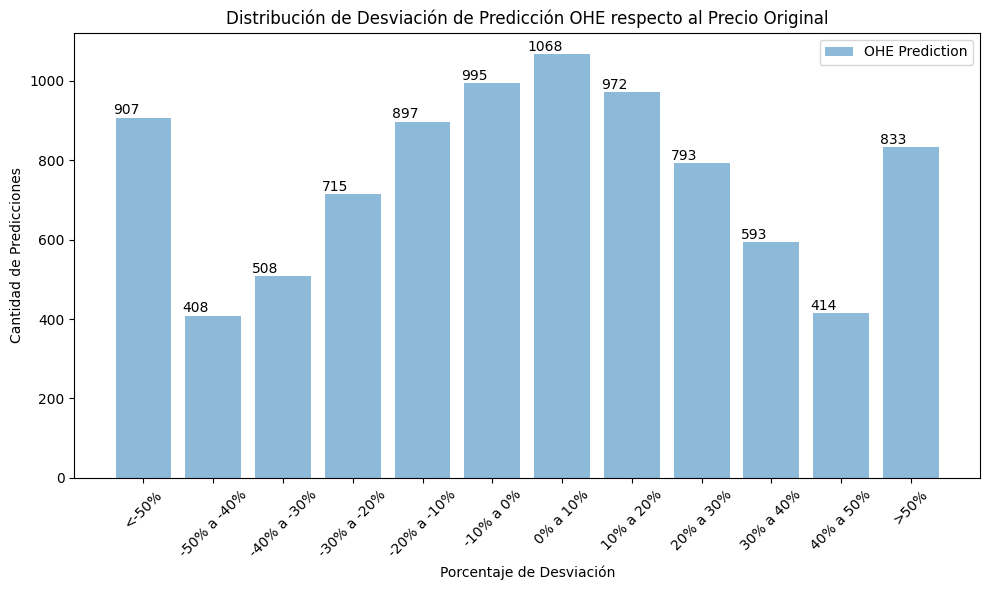

In [6]:
# Gráfico de distribución de desviaciones
plt.figure(figsize=(10, 6))
#plt.bar(simple_counts.index, simple_counts.values, alpha=0.5, label='Simple Prediction')
plt.bar(ohe_counts.index, ohe_counts.values, alpha=0.5, label='OHE Prediction')
#plt.bar(neighborhood_counts.index, neighborhood_counts.values, alpha=0.5, label='Neighborhood Prediction')

for index, value in enumerate(ohe_counts.values):
    plt.text(index - 0.25, value + 1, str(value), ha='center', va='bottom')

plt.xlabel('Porcentaje de Desviación')
plt.ylabel('Cantidad de Predicciones')
plt.title('Distribución de Desviación de Predicción OHE respecto al Precio Original')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

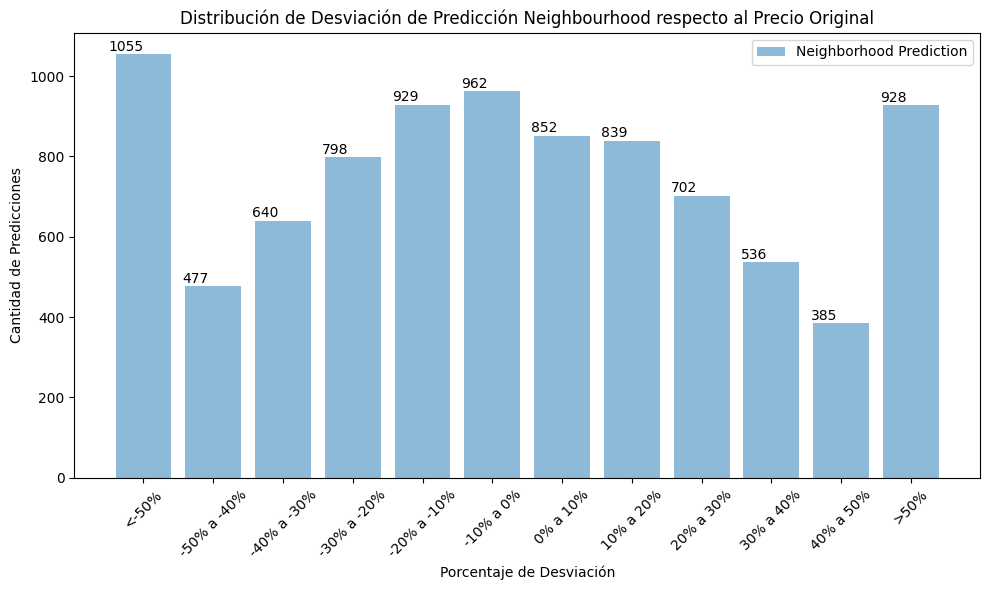

In [7]:
# Gráfico de distribución de desviaciones
plt.figure(figsize=(10, 6))
#plt.bar(simple_counts.index, simple_counts.values, alpha=0.5, label='Simple Prediction')
#plt.bar(ohe_counts.index, ohe_counts.values, alpha=0.5, label='OHE Prediction')
plt.bar(neighborhood_counts.index, neighborhood_counts.values, alpha=0.5, label='Neighborhood Prediction')

for index, value in enumerate(neighborhood_counts.values):
    plt.text(index - 0.25, value + 1, str(value), ha='center', va='bottom')

plt.xlabel('Porcentaje de Desviación')
plt.ylabel('Cantidad de Predicciones')
plt.title('Distribución de Desviación de Predicción Neighbourhood respecto al Precio Original')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [141]:
# Tomando en cuenta que hasta un 30% de desviación es aceptable tenemos los siguientes 
# números para los modelos

# Calcular la precisión de cada modelo (desviación aceptable hasta el 30%)
simple_accuracy = ((df['simple_deviation'].abs() <= 30).sum() / len(df)) * 100
ohe_accuracy = ((df['ohe_deviation'].abs() <= 30).sum() / len(df)) * 100
neighborhood_accuracy = ((df['neighborhood_deviation'].abs() <= 30).sum() / len(df)) * 100

print(f"Precisión Simple Prediction: {simple_accuracy:.2f}%")
print(f"Precisión OHE Prediction: {ohe_accuracy:.2f}%")
print(f"Precisión Neighborhood Prediction: {neighborhood_accuracy:.2f}%")

Precisión Simple Prediction: 55.97%
Precisión OHE Prediction: 59.76%
Precisión Neighborhood Prediction: 55.83%


In [144]:
df_deviation = df.loc[(df.ohe_deviation > 50) | (df.ohe_deviation < -50)]
df_deviation

,argenprop_code,original_price,total_area,rooms,antiquity,neighborhood,bedrooms,bathrooms,garages,simple_prediction,...,neighborhood_prediction,simple_error,ohe_error,neighborhood_error,simple_deviation,ohe_deviation,neighborhood_deviation,simple_dev_category,ohe_dev_category,neighborhood_dev_category
4,160828-6218964,1102500.0,50,1,22,CABALLITO,2,1,1,5.162013e+05,...,393271.556526,-5.862987e+05,-6.652863e+05,-7.092284e+05,-53.179022,-60.343428,-64.329111,<-50%,<-50%,<-50%
6,PRO-971487,4500000.0,217,6,22,CABALLITO,5,1,1,8.799452e+05,...,964057.430053,-3.620055e+06,-3.596188e+06,-3.535943e+06,-80.445661,-79.915293,-78.576502,<-50%,<-50%,<-50%
10,AR.42.8.178.5.V4,300000.0,38,2,40,CABALLITO,1,1,1,5.732677e+05,...,514823.930421,2.732677e+05,2.001396e+05,2.148239e+05,91.089234,66.713194,71.607977,>50%,>50%,>50%
11,PRO-1228597,320000.0,29,1,10,CABALLITO,2,1,1,5.448366e+05,...,467354.331486,2.248366e+05,1.667717e+05,1.473543e+05,70.261429,52.116162,46.048229,>50%,>50%,40% a 50%
14,WR7_63,300000.0,36,1,22,CABALLITO,2,1,1,4.641822e+05,...,375326.001678,1.641822e+05,1.614549e+05,7.532600e+04,54.727413,53.818296,25.108667,>50%,>50%,20% a 30%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9251,PRO-1238178,340000.0,30,2,7,VILLA URQUIZA,1,1,1,5.305556e+05,...,511929.107139,1.905556e+05,1.889658e+05,1.719291e+05,56.045758,55.578170,50.567384,>50%,>50%,>50%
9257,101479-6302122,980000.0,67,1,2,VILLA URQUIZA,2,1,1,5.208656e+05,...,519268.333459,-4.591344e+05,-5.015146e+05,-4.607317e+05,-46.850454,-51.174956,-47.013435,-50% a -40%,<-50%,-50% a -40%
9276,3ODE_39,2200000.0,200,4,30,VILLA URQUIZA,3,1,1,1.061731e+06,...,880473.155285,-1.138269e+06,-1.151974e+06,-1.319527e+06,-51.739478,-52.362446,-59.978493,<-50%,<-50%,<-50%
9282,AR.42.19.496.1.V1,300000.0,44,2,12,VILLA URQUIZA,1,1,1,5.607819e+05,...,378864.582051,2.607819e+05,2.117178e+05,7.886458e+04,86.927289,70.572607,26.288194,>50%,>50%,20% a 30%


In [145]:
df_deviation.to_csv("ArgenpropDeviation.csv", index=False)

In [149]:
df_deviation.shape

(1740, 21)

In [13]:
df_deviation_analysis = df.loc[((df.ohe_deviation > 50) | (df.ohe_deviation < -50))]

df_deviation_analysis.shape
df_deviation_analysis

,argenprop_code,original_price,total_area,rooms,antiquity,neighborhood,bedrooms,bathrooms,garages,simple_prediction,ohe_prediction,neighborhood_prediction,simple_deviation,ohe_deviation,neighborhood_deviation,simple_dev_category,ohe_dev_category,neighborhood_dev_category
4,160828-6218964,1102500.0,50,1,22,CABALLITO,2,1,1,5.162013e+05,4.372137e+05,393271.556526,-53.179022,-60.343428,-64.329111,<-50%,<-50%,<-50%
6,PRO-971487,4500000.0,217,6,22,CABALLITO,5,1,1,8.799452e+05,9.038118e+05,964057.430053,-80.445661,-79.915293,-78.576502,<-50%,<-50%,<-50%
10,AR.42.8.178.5.V4,300000.0,38,2,40,CABALLITO,1,1,1,5.732677e+05,5.001396e+05,514823.930421,91.089234,66.713194,71.607977,>50%,>50%,>50%
11,PRO-1228597,320000.0,29,1,10,CABALLITO,2,1,1,5.448366e+05,4.867717e+05,467354.331486,70.261429,52.116162,46.048229,>50%,>50%,40% a 50%
14,WR7_63,300000.0,36,1,22,CABALLITO,2,1,1,4.641822e+05,4.614549e+05,375326.001678,54.727413,53.818296,25.108667,>50%,>50%,20% a 30%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9251,PRO-1238178,340000.0,30,2,7,VILLA URQUIZA,1,1,1,5.305556e+05,5.289658e+05,511929.107139,56.045758,55.578170,50.567384,>50%,>50%,>50%
9257,101479-6302122,980000.0,67,1,2,VILLA URQUIZA,2,1,1,5.208656e+05,4.784854e+05,519268.333459,-46.850454,-51.174956,-47.013435,-50% a -40%,<-50%,-50% a -40%
9276,3ODE_39,2200000.0,200,4,30,VILLA URQUIZA,3,1,1,1.061731e+06,1.048026e+06,880473.155285,-51.739478,-52.362446,-59.978493,<-50%,<-50%,<-50%
9282,AR.42.19.496.1.V1,300000.0,44,2,12,VILLA URQUIZA,1,1,1,5.607819e+05,5.117178e+05,378864.582051,86.927289,70.572607,26.288194,>50%,>50%,20% a 30%


In [17]:
df_final_filtered = df_final.loc[((df_final.original_price > 300000) & (df_final.original_price < 1500000))]
df_final_filtered

,argenprop_code,original_price,total_area,rooms,antiquity,neighborhood,bedrooms,bathrooms,garages,simple_prediction,ohe_prediction,neighborhood_prediction,simple_deviation,ohe_deviation,neighborhood_deviation,simple_dev_category,ohe_dev_category,neighborhood_dev_category
0,6EBM_5,400000.0,45,1,22,CABALLITO,2,1,1,462710.700576,443067.900467,391351.136726,15.677675,10.766975,-2.162216,10% a 20%,10% a 20%,-10% a 0%
2,BTS1329_LP723065_1,428750.0,25,1,0,CABALLITO,2,1,1,461143.758230,432003.060667,390036.580976,7.555396,0.758731,-9.029369,0% a 10%,0% a 10%,-10% a 0%
3,AR.42.53.104.487.V1,480000.0,54,1,19,CABALLITO,2,1,1,530215.998417,423709.214118,497013.064289,10.461666,-11.727247,3.544388,10% a 20%,-20% a -10%,0% a 10%
4,160828-6218964,1102500.0,50,1,22,CABALLITO,2,1,1,516201.283400,437213.705926,393271.556526,-53.179022,-60.343428,-64.329111,<-50%,<-50%,<-50%
5,DH2310797,370000.0,32,2,10,CABALLITO,1,1,1,797683.919469,519936.925431,512294.158563,115.590249,40.523493,38.457881,>50%,40% a 50%,30% a 40%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9307,BK803710,350000.0,33,2,0,VILLA URQUIZA,1,1,1,487499.845183,553031.202243,532998.520941,39.285670,58.008915,52.285292,30% a 40%,>50%,>50%
9308,OWZ_96,588000.0,50,2,15,VILLA URQUIZA,1,1,1,642440.356141,590311.181462,629393.739799,9.258564,0.393058,7.039752,0% a 10%,0% a 10%,0% a 10%
9309,DG211391,600000.0,46,1,20,VILLA URQUIZA,2,1,1,809723.132479,472058.361075,485344.153924,34.953855,-21.323606,-19.109308,30% a 40%,-30% a -20%,-20% a -10%
9310,PRO-1226719,857500.0,34,2,0,VILLA URQUIZA,1,1,1,668106.576989,564658.005745,556518.911837,-22.086697,-34.150670,-35.099835,-30% a -20%,-40% a -30%,-40% a -30%


In [18]:
import matplotlib.pyplot as plt

df = df_final_filtered

# Crear columnas de porcentaje de desviación
# Fórmula: (predicción - valor real) / valor real * 100
df['simple_deviation'] = ((df['simple_prediction'] - df['original_price']) / df['original_price']) * 100
df['ohe_deviation'] = ((df['ohe_prediction'] - df['original_price']) / df['original_price']) * 100
df['neighborhood_deviation'] = ((df['neighborhood_prediction'] - df['original_price']) / df['original_price']) * 100

# Categorizar las desviaciones en rangos
bins = [-float('inf'), -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, float('inf')]
labels = ['<-50%', '-50% a -40%', '-40% a -30%', '-30% a -20%', '-20% a -10%', '-10% a 0%', '0% a 10%', '10% a 20%', '20% a 30%', '30% a 40%', '40% a 50%', '>50%']

df['simple_dev_category'] = pd.cut(df['simple_deviation'], bins=bins, labels=labels)
df['ohe_dev_category'] = pd.cut(df['ohe_deviation'], bins=bins, labels=labels)
df['neighborhood_dev_category'] = pd.cut(df['neighborhood_deviation'], bins=bins, labels=labels)

# Contar la frecuencia de cada categoría
simple_counts = df['simple_dev_category'].value_counts().sort_index()
ohe_counts = df['ohe_dev_category'].value_counts().sort_index()
neighborhood_counts = df['neighborhood_dev_category'].value_counts().sort_index()

/var/folders/nh/hlj82q8x3lb09bztb9v347pwp22f50/T/ipykernel_82717/1472659650.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['simple_deviation'] = ((df['simple_prediction'] - df['original_price']) / df['original_price']) * 100
/var/folders/nh/hlj82q8x3lb09bztb9v347pwp22f50/T/ipykernel_82717/1472659650.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ohe_deviation'] = ((df['ohe_prediction'] - df['original_price']) / df['original_price']) * 100
/var/folders/nh/hlj82q8x3lb09bztb9v347pwp22f50/T/ipy

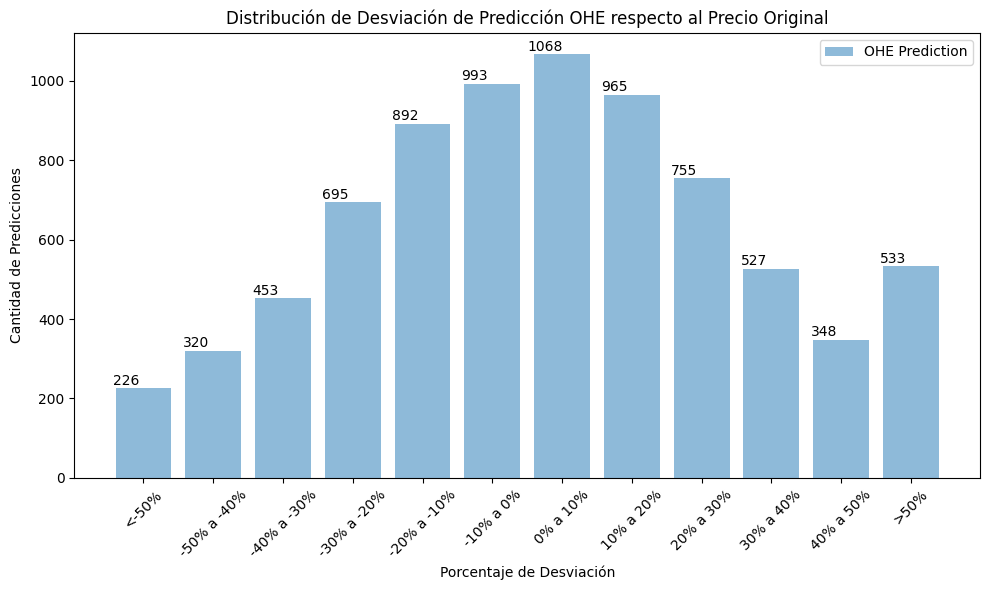

In [19]:
# Gráfico de distribución de desviaciones
plt.figure(figsize=(10, 6))
#plt.bar(simple_counts.index, simple_counts.values, alpha=0.5, label='Simple Prediction')
plt.bar(ohe_counts.index, ohe_counts.values, alpha=0.5, label='OHE Prediction')
#plt.bar(neighborhood_counts.index, neighborhood_counts.values, alpha=0.5, label='Neighborhood Prediction')

for index, value in enumerate(ohe_counts.values):
    plt.text(index - 0.25, value + 1, str(value), ha='center', va='bottom')

plt.xlabel('Porcentaje de Desviación')
plt.ylabel('Cantidad de Predicciones')
plt.title('Distribución de Desviación de Predicción OHE respecto al Precio Original')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

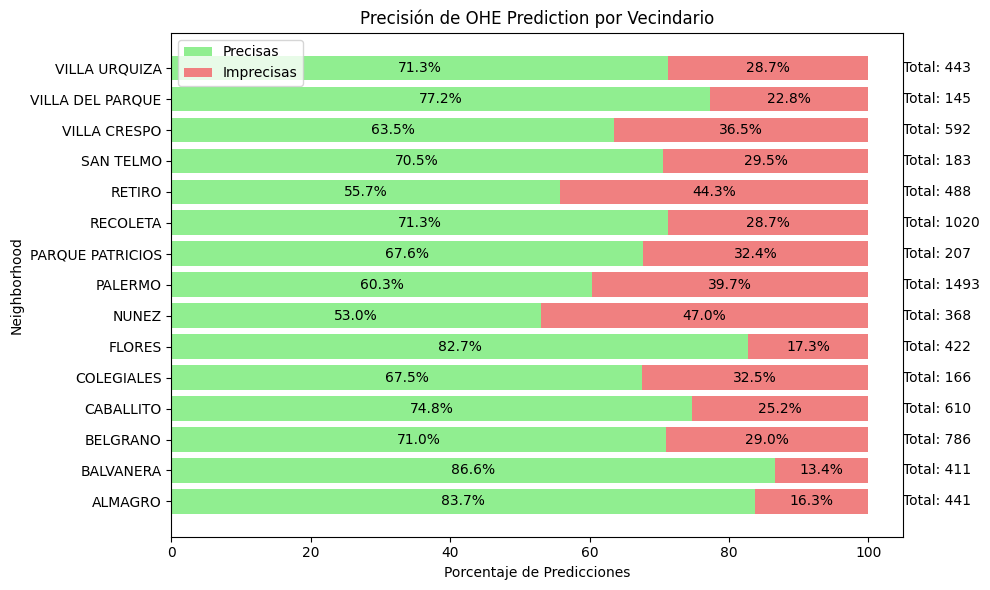

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV

# Calcular precisión e imprecisión por vecindario para cada tipo de desviación
simple_accuracy_by_neighborhood = df_final_filtered.groupby('neighborhood')['simple_deviation'].apply(lambda x: (x.abs() <= 30).mean() * 100)
simple_inaccuracy_by_neighborhood = 100 - simple_accuracy_by_neighborhood
simple_counts = df_final_filtered['neighborhood'].value_counts().sort_index()


ohe_accuracy_by_neighborhood = df_final_filtered.groupby('neighborhood')['ohe_deviation'].apply(lambda x: (x.abs() <= 30).mean() * 100)
ohe_inaccuracy_by_neighborhood = 100 - ohe_accuracy_by_neighborhood
ohe_counts = df_final_filtered['neighborhood'].value_counts().sort_index()


neighborhood_accuracy_by_neighborhood = df_final_filtered.groupby('neighborhood')['neighborhood_deviation'].apply(lambda x: (x.abs() <= 30).mean() * 100)
neighborhood_inaccuracy_by_neighborhood = 100 - neighborhood_accuracy_by_neighborhood
neighborhood_counts = df_final_filtered['neighborhood'].value_counts().sort_index()


# Función para crear gráficos de barras apiladas con números en cada barra
def plot_stacked_barh(accuracy, inaccuracy, counts, title):
    plt.figure(figsize=(10, 6))
    bars1 = plt.barh(accuracy.index, accuracy.values, color='lightgreen', label='Precisas')
    bars2 = plt.barh(inaccuracy.index, inaccuracy.values, left=accuracy.values, color='lightcoral', label='Imprecisas')

    # Agregar números sobre las barras
    for bar, value in zip(bars1, accuracy.values):
        plt.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{value:.1f}%', ha='center', va='center', color='black')
    for bar, value, left in zip(bars2, inaccuracy.values, accuracy.values):
        plt.text(left + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{value:.1f}%', ha='center', va='center', color='black')

    # Agregar el total de casos a la derecha de cada barra
    for index, total in enumerate(counts.loc[accuracy.index]):
        plt.text(105, index, f'Total: {total}', ha='left', va='center', color='black')
    
    plt.xlabel('Porcentaje de Predicciones')
    plt.ylabel('Neighborhood')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Gráficos para cada tipo de desviación
plot_stacked_barh(ohe_accuracy_by_neighborhood, ohe_inaccuracy_by_neighborhood, ohe_counts, 'Precisión de OHE Prediction por Vecindario')

In [21]:
# Tomando en cuenta que hasta un 30% de desviación es aceptable tenemos los siguientes 
# números para los modelos

# Calcular la precisión de cada modelo (desviación aceptable hasta el 30%)
simple_accuracy = ((df_final_filtered['simple_deviation'].abs() <= 30).sum() / len(df)) * 100
ohe_accuracy = ((df_final_filtered['ohe_deviation'].abs() <= 30).sum() / len(df)) * 100
neighborhood_accuracy = ((df_final_filtered['neighborhood_deviation'].abs() <= 30).sum() / len(df)) * 100

print(f"Precisión Simple Prediction: {simple_accuracy:.2f}%")
print(f"Precisión OHE Prediction: {ohe_accuracy:.2f}%")
print(f"Precisión Neighborhood Prediction: {neighborhood_accuracy:.2f}%")

Precisión Simple Prediction: 64.87%
Precisión OHE Prediction: 69.04%
Precisión Neighborhood Prediction: 64.14%


In [24]:
df_deviation = df_final_filtered.loc[(df_final_filtered.ohe_deviation > 50) | (df_final_filtered.ohe_deviation < -50)]
df_deviation.head(20)


,argenprop_code,original_price,total_area,rooms,antiquity,neighborhood,bedrooms,bathrooms,garages,simple_prediction,ohe_prediction,neighborhood_prediction,simple_deviation,ohe_deviation,neighborhood_deviation,simple_dev_category,ohe_dev_category,neighborhood_dev_category
4,160828-6218964,1102500.0,50,1,22,CABALLITO,2,1,1,516201.283400,4.372137e+05,3.932716e+05,-53.179022,-60.343428,-64.329111,<-50%,<-50%,<-50%
11,PRO-1228597,320000.0,29,1,10,CABALLITO,2,1,1,544836.571260,4.867717e+05,4.673543e+05,70.261429,52.116162,46.048229,>50%,>50%,40% a 50%
164,CS021207,450000.0,55,2,70,ALMAGRO,1,1,1,603910.946591,6.994613e+05,7.796593e+05,34.202433,55.435849,73.257613,30% a 40%,>50%,>50%
169,AR.42.123.125.2,320000.0,32,2,11,ALMAGRO,1,1,1,772797.393584,4.903342e+05,4.728527e+05,141.499185,53.229431,47.766474,>50%,>50%,40% a 50%
196,CD681082,370000.0,60,3,5,ALMAGRO,2,1,1,885673.645190,6.675231e+05,7.130024e+05,139.371255,80.411636,92.703355,>50%,>50%,>50%
204,PRO-1252867,1200000.0,60,2,20,ALMAGRO,1,1,1,815320.764710,5.477910e+05,4.879056e+05,-32.056603,-54.350750,-59.341199,-40% a -30%,<-50%,<-50%
261,DH391449,430000.0,55,2,28,ALMAGRO,1,1,1,812301.628508,6.737428e+05,6.087836e+05,88.907355,56.684364,41.577570,>50%,>50%,40% a 50%
319,AR.42.14.100.124,400000.0,77,3,10,ALMAGRO,2,1,1,814083.998527,6.732597e+05,7.459107e+05,103.521000,68.314915,86.477680,>50%,>50%,>50%
328,DE611393,310000.0,50,3,5,ALMAGRO,2,1,1,827421.902510,6.743170e+05,6.318533e+05,166.910291,117.521600,103.823657,>50%,>50%,>50%
574,65JF_135580,430000.0,70,3,0,BALVANERA,2,1,1,634844.943885,6.689472e+05,6.938928e+05,47.638359,55.569116,61.370426,40% a 50%,>50%,>50%


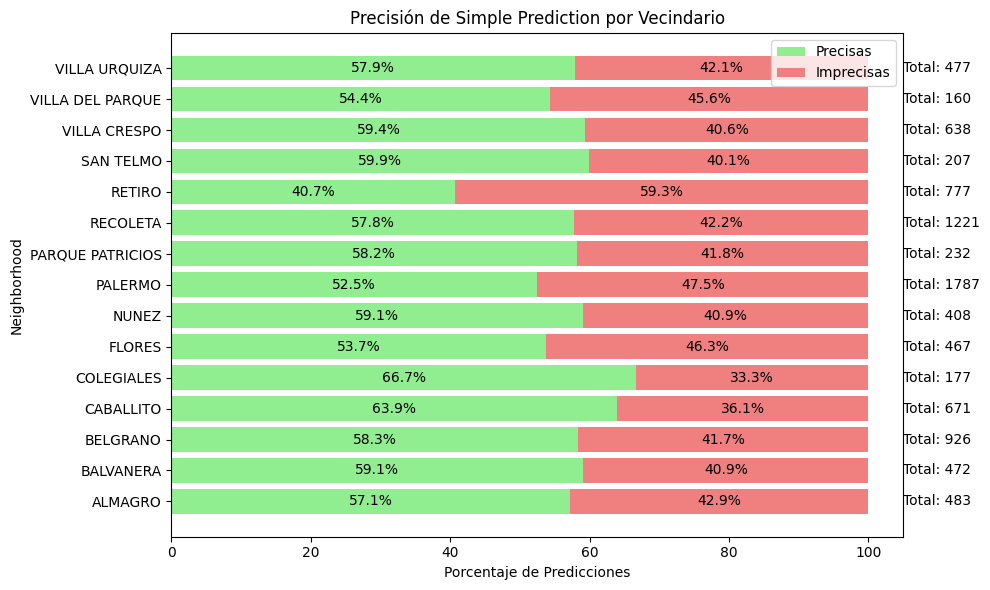

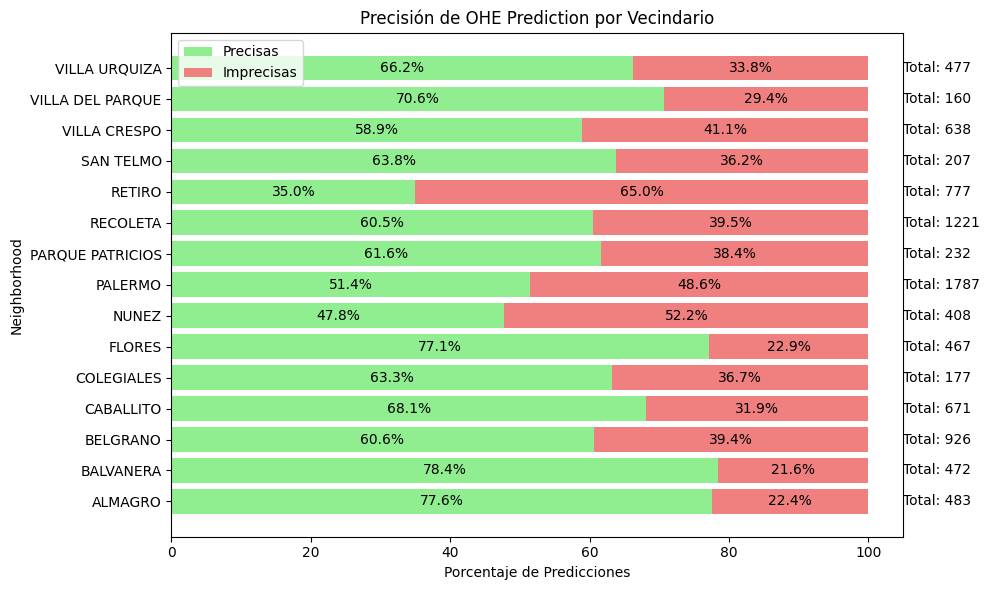

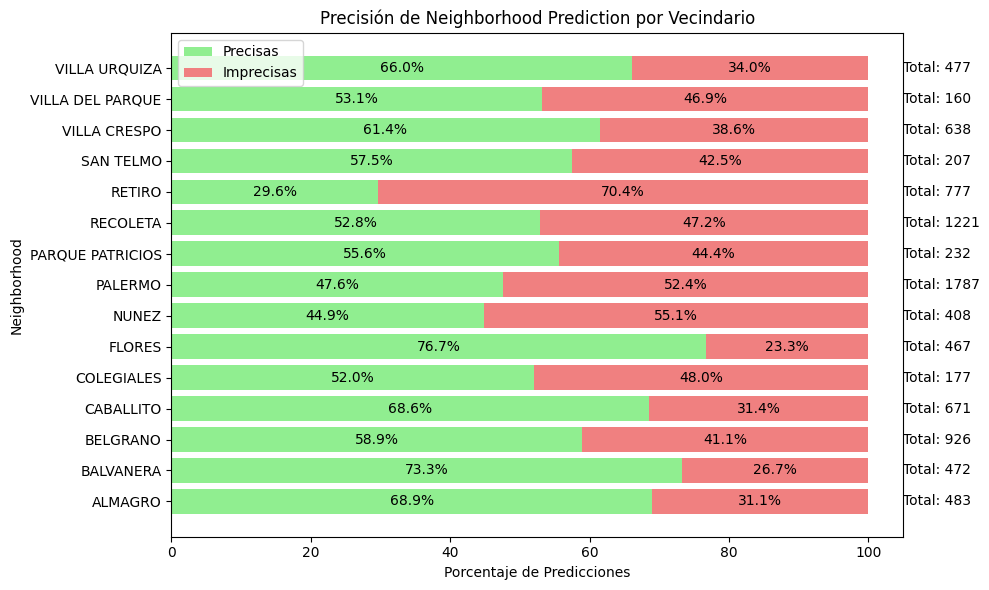

In [168]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el CSV

# Calcular precisión e imprecisión por vecindario para cada tipo de desviación
simple_accuracy_by_neighborhood = df.groupby('neighborhood')['simple_deviation'].apply(lambda x: (x.abs() <= 30).mean() * 100)
simple_inaccuracy_by_neighborhood = 100 - simple_accuracy_by_neighborhood
simple_counts = df['neighborhood'].value_counts().sort_index()


ohe_accuracy_by_neighborhood = df.groupby('neighborhood')['ohe_deviation'].apply(lambda x: (x.abs() <= 30).mean() * 100)
ohe_inaccuracy_by_neighborhood = 100 - ohe_accuracy_by_neighborhood
ohe_counts = df['neighborhood'].value_counts().sort_index()


neighborhood_accuracy_by_neighborhood = df.groupby('neighborhood')['neighborhood_deviation'].apply(lambda x: (x.abs() <= 30).mean() * 100)
neighborhood_inaccuracy_by_neighborhood = 100 - neighborhood_accuracy_by_neighborhood
neighborhood_counts = df['neighborhood'].value_counts().sort_index()


# Función para crear gráficos de barras apiladas con números en cada barra
def plot_stacked_barh(accuracy, inaccuracy, counts, title):
    plt.figure(figsize=(10, 6))
    bars1 = plt.barh(accuracy.index, accuracy.values, color='lightgreen', label='Precisas')
    bars2 = plt.barh(inaccuracy.index, inaccuracy.values, left=accuracy.values, color='lightcoral', label='Imprecisas')

    # Agregar números sobre las barras
    for bar, value in zip(bars1, accuracy.values):
        plt.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{value:.1f}%', ha='center', va='center', color='black')
    for bar, value, left in zip(bars2, inaccuracy.values, accuracy.values):
        plt.text(left + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{value:.1f}%', ha='center', va='center', color='black')

    # Agregar el total de casos a la derecha de cada barra
    for index, total in enumerate(counts.loc[accuracy.index]):
        plt.text(105, index, f'Total: {total}', ha='left', va='center', color='black')
    
    plt.xlabel('Porcentaje de Predicciones')
    plt.ylabel('Neighborhood')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Gráficos para cada tipo de desviación
plot_stacked_barh(simple_accuracy_by_neighborhood, simple_inaccuracy_by_neighborhood, simple_counts, 'Precisión de Simple Prediction por Vecindario')
plot_stacked_barh(ohe_accuracy_by_neighborhood, ohe_inaccuracy_by_neighborhood, ohe_counts, 'Precisión de OHE Prediction por Vecindario')
plot_stacked_barh(neighborhood_accuracy_by_neighborhood, neighborhood_inaccuracy_by_neighborhood, neighborhood_counts, 'Precisión de Neighborhood Prediction por Vecindario')